## 4.3 Policy Iteration

Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited 10 dollars by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are avialable when they are needed, Jack can move them between the two locations overnight, at a cost of 2 dollars per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number if $n$ is $\frac {\lambda^n} {n!} e^{-\lambda}$, where $\lambda$ is the expected number. Suppose $\lambda$ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be $\gamma = 0.9$ and formulate this as a continuing finie MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.

### Exercise 4.7:

Write a program for policy iteration and re-solve Jac's car rental problem with the following changes. One of Jack's employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs 2.00 dollars, as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of 4 dollars must be incurred to use a second parking lot (independent of how many cars are kept there). These sorts of nonlinearities and arbitrary dynamics often occur in real problems and cannot easily be handled by optimization methods other than dynamic programming. To check your rogram, first replicate the results given for the original problem.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

## The Poisson Distribution

First, we will define a pmf for the Poisson distribution. This will be useful for defining other things throughout the problem.

$$
f(k;\lambda) = \frac {\lambda^ke^{-\lambda}} {k!}
$$



In [2]:

def factorial(n):
    r = 1

    for i in range(1, n + 1):
        r *= i

    return r


def poisson_pmf(lambd, k):
    """
    Compute the poisson probability of k events happening within the time interval lambda.
    """
    return pow(lambd, k) * math.exp(-lambd) / factorial(k)


The probability that an event happens 10 or less times is 0.9997262831771443


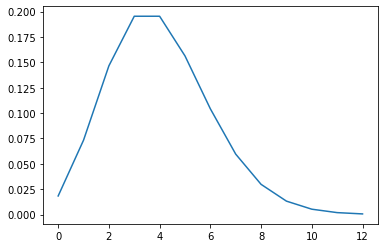

In [3]:
poisson_samples = [poisson_pmf(4.0, i) for i in range(0, 13)]

plt.plot(poisson_samples)

print("The probability that an event happens 10 or less times is %s" % (np.sum(poisson_samples)))


Note that above, we compute the Poisson Distribution (with $\lambda = 4$) from k = 0 to 15. The cumalitive probability of an event happening at most 15 times with our given lambda is 99.9%. Because the Poisson distribution is defined up to Infinity, we need a reasonable cut-off point to estimate the probability distributions that we are using. For that reason, we will cut our Poisson calculations at 15. To make sure that probabilities still add up to 1, we will redistribute our distribute by setting a denominator to be the total probability of k <= 15. In addition, because we know that we want the Poisson distributions for $\lambda$ 2, 3, and 4, we will pre-compute those values here.

In [4]:
# Because Poisson is defined up to Infinity, but the vast majority of
# probability density is clustered at lower values, we estimate the
# distribution by computing up to some max number for our poisson outcome and
# dividing by the total density to ensure that all our probabilities add to 1.
#
# When choosing the poisson cutoff number (defined below), there is a trade-off
# between how accurately we our simulating the Poisson distribution and how
# efficient our algorithm is.

POISSON_COUNT=8

poisson_pmf_2 = np.array([poisson_pmf(2.0, i) for i in range(0, POISSON_COUNT)])
poisson_pmf_3 = np.array([poisson_pmf(3.0, i) for i in range(0, POISSON_COUNT)])
poisson_pmf_4 = np.array([poisson_pmf(4.0, i) for i in range(0, POISSON_COUNT)])

original_sum_2 = np.sum(poisson_pmf_2)
original_sum_3 = np.sum(poisson_pmf_3)
original_sum_4 = np.sum(poisson_pmf_4)

poisson_pmf_2 /= np.sum(poisson_pmf_2)
poisson_pmf_3 /= np.sum(poisson_pmf_3)
poisson_pmf_4 /= np.sum(poisson_pmf_4)

# From the PMF values, let us compute the CDF values as well. It is easier to
# work with CDF's when calculating probability from a uniform random
# number generator.
poisson_cdf_2 = np.array(poisson_pmf_2)
poisson_cdf_3 = np.array(poisson_pmf_3)
poisson_cdf_4 = np.array(poisson_pmf_4)

for i in range(1, POISSON_COUNT):
    poisson_cdf_2[i] += poisson_cdf_2[i-1]
    poisson_cdf_3[i] += poisson_cdf_3[i-1]
    poisson_cdf_4[i] += poisson_cdf_4[i-1]


original_sum_2, original_sum_3, original_sum_4



(0.9989032810321414, 0.9880954961436427, 0.9488663842071525)

In [5]:
# We will also pre-compute the possible Poisson outcomes.

NUM_POISSON_POSSIBILITIES = POISSON_COUNT * POISSON_COUNT * POISSON_COUNT * POISSON_COUNT

poisson_outcomes = np.zeros((NUM_POISSON_POSSIBILITIES, 4))
poisson_joint_probs = np.ones(NUM_POISSON_POSSIBILITIES)

for i in range(POISSON_COUNT):
    index_i = i * POISSON_COUNT * POISSON_COUNT * POISSON_COUNT

    for j in range(POISSON_COUNT):
        index_j = index_i  + (j * POISSON_COUNT * POISSON_COUNT)

        for k in range(POISSON_COUNT):
            index_k = index_j + (k * POISSON_COUNT)

            for l in range (POISSON_COUNT):
                index = index_k + l

                poisson_outcomes[index, :] = [i, j, k, l]
                poisson_joint_probs[index] = poisson_pmf_3[i] * poisson_pmf_2[j] * poisson_pmf_3[k] * poisson_pmf_4[l]   # Rentals B


poisson_outcomes[1000:1010, :]

array([[1., 7., 5., 0.],
       [1., 7., 5., 1.],
       [1., 7., 5., 2.],
       [1., 7., 5., 3.],
       [1., 7., 5., 4.],
       [1., 7., 5., 5.],
       [1., 7., 5., 6.],
       [1., 7., 5., 7.],
       [1., 7., 6., 0.],
       [1., 7., 6., 1.]])

In [6]:
# Sanity Check: Make sure that the poisson pmf's are summing to 1.

DELTA = 1e-5

assert(abs(np.sum(poisson_pmf_2) - 1.0) < DELTA)
assert(abs(np.sum(poisson_pmf_3) - 1.0) < DELTA)
assert(abs(np.sum(poisson_pmf_4) - 1.0) < DELTA)

# Sanity Check: Make sure the sum of all join probabilities is 1. 

assert(abs(np.sum(poisson_joint_probs) - 1.0) < DELTA)




In [45]:
def choose_poisson(cdf, n):
    random_values = np.random.rand(n)
    choices = np.zeros(n)
    choice_masks = random_values > cdf[0]

    for i in range(1, POISSON_COUNT):
        choose_this_outcome = choice_masks & (random_values <= cdf[i])
        choice_masks &= ~choose_this_outcome
        choices += (choose_this_outcome * i)

    return choices


In [62]:
# Sanity Check: Choosing samples from a Poisson distribution gives
# reasonable results.

choices = choose_poisson(poisson_cdf_2, 10000)

assert np.max(choices) <= POISSON_COUNT - 1
assert np.min(choices) >= 0



## Pre-Computing the Rental / Return Possibilities for Each Day

During each day, a certain number of cars are rented and returned at each location. Because we are setting a max possibility for our Poisson outcomes, there is a finite number of possible rental / return scenarios. Each rental / return scenario
also yields a reward -- revenue from cars returned. We will represent this as a 4-dimensional matrix of possibilities -- the dimensions are (1) returns at location A, (2) returns at location B, (3) rentals at location A, (4) rentals at location B, and the element at the position of the matrix is the probability of that particular outcome.


In [7]:
poisson_matrix = np.ones((POISSON_COUNT, POISSON_COUNT, POISSON_COUNT, POISSON_COUNT))

for i in range(0, POISSON_COUNT):
    for j in range(0, POISSON_COUNT):
        for k in range(0, POISSON_COUNT):
            poisson_matrix[:, i, j, k] *= poisson_pmf_3 # Returns @ A
            poisson_matrix[i, :, j, k] *= poisson_pmf_4 # Returns @ B
            poisson_matrix[i, j, :, k] *= poisson_pmf_3 # Rentals @ A
            poisson_matrix[i, j, k, :] *= poisson_pmf_2 # Rentals @ B

np.prod(np.shape(poisson_matrix)), np.sum(poisson_matrix[:])




(4096, 0.9999999999999999)

In [8]:
np.concatenate([np.ones((10, 1)), np.zeros((10, 2))], axis=1)

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [9]:
# A quick sanity check: Need to validate that the sum of all elements in the matrix is 1 (the probability of any possibility happening).
DELTA = 1e-5

assert(np.abs(np.sum(poisson_matrix[:]) - 1) < DELTA)

## The Original Problem

Let's start by solving the original problem, and verify that we get the same solution described in the book.

First, we need to correctly model the problem in terms of the value functions and probability distributions.

- The possible states are the number of cars at each location, which is no more than 20. That means a total of 21 * 21 = 441 states.
- There are at most 6 possible actions from each state (moving up to 5 cars from one location to another). Note that we ignore strictly dominated actions, such as moving 3 cars from location A to location B and 3 cars from location B to location A, which is strictly worse than not moving any cars at all.
- The reward per day is the amount earned from rentals minus the cost of moving cars from the night before.

We need to know the full probabilty distribution $p(s', r | s, a)$. So for each state-action pair, we need the probability of each state-reward pair.
- There are 441 states, each containing at most 11 actions, so there is an upper limit of 441 * 11 = 4851 state-action pairs.
- For each state-action pair, we need the probability of any possible target state, reward pair.
- This number will start to get large, so we will define a function that, given a state-action pair, will compute a sequence of probability, next state, reward triples.

### Defining Utility Functions



In [10]:
# Important constants we will use throughout the remainder of the notebook.
MAX_CARS_PER_LOCATION = 20
COST_PER_CAR_MOVED = 2
REVENUE_PER_CAR_RENTED = 10
MAX_MOVES_DAILY = 5

ALL_STATES = np.zeros(((MAX_CARS_PER_LOCATION + 1) * (MAX_CARS_PER_LOCATION + 1), 2)).astype(int)

for i in range(0, MAX_CARS_PER_LOCATION + 1):
    for j in range(0, MAX_CARS_PER_LOCATION + 1):
        ALL_STATES[i * (MAX_CARS_PER_LOCATION + 1) + j, :] = [i, j]


In [11]:
def state_for_index(indices):
    if np.shape(indices) == ():
        cars_b = indices % (MAX_CARS_PER_LOCATION + 1)
        cars_a = int((indices - cars_b) / (MAX_CARS_PER_LOCATION + 1))
        return (cars_a, cars_b)

    cars_b = indices % (MAX_CARS_PER_LOCATION + 1)
    cars_a = (indices - cars_b) / (MAX_CARS_PER_LOCATION + 1)
    return np.concatenate([cars_a, cars_b], axis=-1)


def index_for_state(states):
    if np.shape(states) == (2,):
        return (MAX_CARS_PER_LOCATION + 1) * states[0] + states[1]
    
    return ((MAX_CARS_PER_LOCATION + 1) * states[:, 0] + states[:, 1]).astype(int)


In [12]:
# TODO: Make these utilities vectorized compatible.

# Actions can take on values between -MAX_MOVES_DAILY and MAX_MOVES_DAILY.

ACTION_ARRAY_LEN = 2 * MAX_MOVES_DAILY + 1

def index_for_action(action):
    assert(abs(action) <= MAX_MOVES_DAILY)
    return action + MAX_MOVES_DAILY


def action_for_index(index):
    assert(index >= 0 and index < ACTION_ARRAY_LEN)
    return index - MAX_MOVES_DAILY


In [13]:
# Let's calculate a set of possible actions given the current state.

def possible_actions(state):
    cars_a, cars_b = state
    min_action = -min(cars_b, MAX_MOVES_DAILY)
    max_action = min(cars_a, MAX_MOVES_DAILY)
    return range(min_action, max_action + 1)


In [14]:
# Let's precalculate the set of possible actions that an agent can take at
# any given state. We will define this as a 3D matrix, where the dimensions
# are [cars_a, cars_b, action_index] and each entry in the matrix is a 1 or 0,
# indicating if that particular action can be taken given the number of cars
# at locations A and B.
possible_actions_matrix = np.zeros((len(ALL_STATES), ACTION_ARRAY_LEN))

for i in range(len(ALL_STATES)):
    actions = possible_actions(ALL_STATES[i, :])
    action_indices = [index_for_action(action) for action in actions]
    possible_actions_matrix[i, action_indices] = 1


In [15]:
# Sanity Check: Test a few entries in the possible actions matrix to make sure
# they are correct.

assert possible_actions_matrix[index_for_state((0, 0)), index_for_action(0)] == 1
assert possible_actions_matrix[index_for_state((20, 20)), index_for_action(5)] == 1
assert possible_actions_matrix[index_for_state((2, 2)), index_for_action(3)] == 0

In [16]:
def perform_action(state, action):
    """
    """
    assert(abs(action) <= MAX_MOVES_DAILY)

    # Start by moving cars overnight. This is deterministic. We are assuming
    # all actions are valid.

    cars_a = min(MAX_CARS_PER_LOCATION, state[0] + action)
    cars_b = min(MAX_CARS_PER_LOCATION, state[1] - action)

    # The following day, a certain number of cars are rented, and a certain
    # number are returned to / from each location. We are fully quantifying
    # over the entire join distribution of rentals and returns at each
    # location.

    # NOTE: We are assuming that cars that all the returns on a particular day
    # happen before the rentals for that day.

    poisson_delta_a = np.reshape(poisson_outcomes[:, 0] - poisson_outcomes[:, 2], (-1, 1))
    poisson_delta_b = np.reshape(poisson_outcomes[:, 1] - poisson_outcomes[:, 3], (-1, 1))

    # Calculate the next states for each poisson outcome.
    next_states = np.concatenate([poisson_delta_a, poisson_delta_b], axis=1)
    next_states[:, 0] += cars_a
    next_states[:, 1] += cars_b
    next_states = np.maximum(0, np.minimum(MAX_CARS_PER_LOCATION, next_states))

    # Figure out the total number of rentals for each poisson outcome. We
    # need to account for the fact that a location may not have enough cars to
    # fulfill all rental requests for the day. A location is paid based on the
    # number of fulfilled rentals, not on the number of rental requests.
    total_rentals_a = np.minimum(poisson_outcomes[:, 2], poisson_outcomes[:, 0] + cars_a)
    total_rentals_b = np.minimum(poisson_outcomes[:, 3], poisson_outcomes[:, 1] + cars_b)

    # Figure out the total reward for each Poisson outcome.
    rewards = np.zeros(len(next_states))
    rewards[:] = -abs(action) * COST_PER_CAR_MOVED
    rewards += (total_rentals_a + total_rentals_b) * REVENUE_PER_CAR_RENTED

    return next_states, rewards


In [17]:
# Sanity Check: Make sure that the shape of the result of performing an action is correct.

next_states, rewards = perform_action((2, 2), 2)

assert np.shape(next_states) == (len(poisson_outcomes), 2)
assert np.shape(rewards) == (len(poisson_outcomes),)


In [18]:
def expected_reward(rewards):
    """
    """
    return np.sum(poisson_joint_probs * rewards)

In [19]:
# Let's try performing an action on a demo state and inspect the resulting
# possible outcomes.

_, rewards1 = perform_action((2, 2), 2)
_, rewards2 = perform_action((5, 5), 2)
_, rewards3 = perform_action((10, 10), 2)

# Sanity check: The expected when there are more cars at both locations should
# be more since we have more cars to rent out.

exp1 = expected_reward(rewards1)
exp2 = expected_reward(rewards2)
exp3 = expected_reward(rewards3)

assert exp2 > exp1
assert exp3 > exp2


### Defining an Agent / Policy

Let's start by defining a basic agent that can:
- Observe the current state (# cars at each location)
- Pick an action -- or pick probabilities on a set of actions -- to perform at that state (# cars to move between locations)

Our initial agent will randomly choose from the set of all possible actions at
each state.

In [20]:
class RandomAgent:
    """
    An agent that randomly chooses between a set of all possible actions given
    the current state.
    """

    def policy(self, states):
        """
        The policy takes the current states and, for each state, returns 
        the set of probabilities that the agent would take each action. This
        is a vectorized operation, so if multiple states are provided, multiple
        probability actions are returned.
        """
        state_indices = index_for_state(states)
        probs = possible_actions_matrix[state_indices, :]
        possible_counts = np.reshape(np.sum(probs, axis=-1), (-1, 1))
        probs /= possible_counts
        return probs


In [21]:
# Sanity Check: Let's see that our agent is correctly returning policies
# where the total probability of choosing an action sums to 1.

agent = RandomAgent()
probs = agent.policy(ALL_STATES)
sum_probs = np.sum(probs, axis=-1)

# Asserting that the sum of all probabilities are within 1e-5 from 1.
assert np.sum(np.abs(sum_probs - 1) < 1e-5) == len(ALL_STATES)



### Policy Evaluation

Now that we have a working agent, let's evaluate it. We will use the Bellman Equations to derive the value function for this agent, but also define an evaluation algorithm that will work for evaluating general agents / policies.

$$\large v(s) \leftarrow \sum_a \pi(a | s) \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$


Because each location has at most 20 cars, we have 21 * 21 = 441 possible states that we need values for (including the case of 0 cars at either location). We will define our value function as a 21x21 matrix, where each entry is the value for a particular number of cars.

Section 4.1 in the Sutton textbook describes the algorithm for evaluating a policy. We implement the in-place version of the algorithm because it is simpler, often converges faster, and is more memory-efficient.

In [22]:
def evaluate_agent_policy(agent, discount, max_k):
    """
    Given an agent, evaluate that agent's policy. This returns the values
    for each state given the policy and the number of iterations it took
    to converge.
    """ 

    state_values = np.zeros(len(ALL_STATES))

    k = 0
    max_delta = float('inf')

    while k < max_k:
        max_delta = 0

        print(f"Starting iteration {k}")

        action_probs = agent.policy(ALL_STATES)

        assert len(action_probs) == len(ALL_STATES)

        # PERF: This part of the computation is slow. For each state, computing
        # all possible actions from that state by the agent, and for each
        # of those actions, collecting the full join poisson distribution.
        for i in range(len(ALL_STATES)):
            for action_index in range(ACTION_ARRAY_LEN):
                action_prob = action_probs[i, action_index]
                if action_prob == 0: continue

                state = ALL_STATES[i, :]
                action = action_for_index(action_index)
                next_states, rewards = perform_action(state, action)
                next_state_indices = index_for_state(next_states)
                next_state_values = state_values[next_state_indices]

                new_value = np.sum(poisson_joint_probs * poisson_joint_probs * (rewards + discount * next_state_values))
                state_values[i] = new_value

        print(f"Finished iteration {k}")

        k += 1


    return np.reshape(state_values, (MAX_CARS_PER_LOCATION + 1, MAX_CARS_PER_LOCATION + 1), order='C')


In [23]:
nex_states, rewards = perform_action((2, 2), 2)
index_for_state(next_states).astype(int)


array([84, 84, 84, ..., 86, 85, 84])

In [24]:
random_agent = RandomAgent()
values = evaluate_agent_policy(random_agent, discount=0.9, max_k=4)

Starting iteration 0
Finished iteration 0
Starting iteration 1
Finished iteration 1
Starting iteration 2
Finished iteration 2
Starting iteration 3
Finished iteration 3


## Simulating Agent Runs

Let's create a program that takes an agent and a start state, then runs a simulation over *n* days of the agent moving cars and acquiring rewards from rentals.

In [39]:
def agent_choose_action(agent, states):
    """
    Use the agent's policy to choose an action at the given state.
    """
    probs = agent.policy(states)

    # Choose an action for each state. The choice is a random number between
    # 0 and 1 and we will use the policy probabilities to associate these
    # random numbers with actions.
    prob_choices = np.random.rand(len(states))

    action_choices = np.zeros(len(states))

    # Using the mask to keep track of which action choices have been locked
    # in and which action choices we are still figuring out.
    action_choice_masks = prob_choices > probs[:, 0]

    for action_index in range(1, ACTION_ARRAY_LEN):
        # Accumulating the probabilities. So the probability at the
        # action index is now the probability that an action of that index
        # or smaller index is chosen.
        probs[:, action_index] += probs[:, action_index - 1]

        # Of the action choices that have not yet been chosen, figure out
        # which ones are associated with the current action index.
        choose_current_action = action_choice_masks * (prob_choices <= probs[:, action_index])

        action_choices = action_choices + (choose_current_action * action_index)

        # Remove the actions that were chosen this pass from the set of
        # actions left to choose.
        action_choice_masks &= ~choose_current_action

    # We have made an action choice for each state.
    assert np.sum(action_choice_masks == 0) == len(action_choice_masks)

    # Probabilities for agent policy on each state should sum to 1.
    assert np.sum(np.abs(probs[:, -1] - 1.0) < 1e-5) == len(action_choice_masks)

    return action_choices.astype(int)


In [43]:
# Sanity Check: Agent with deterministic policy will result in clear choice.

class NeverMoveCarsAgent:
    def policy(self, states):
        action_index = index_for_action(0)
        policy_matrix = np.zeros((len(states), ACTION_ARRAY_LEN))
        policy_matrix[:, action_index] = 1.0
        return policy_matrix


choices1 = agent_choose_action(agent=NeverMoveCarsAgent(), states=ALL_STATES)

assert np.sum(choices1 == index_for_action(0)) == len(choices1)

# Sanity Check: Random agent correctly chooses actions. 

choices2 = agent_choose_action(agent=RandomAgent(), states=ALL_STATES)

assert np.sum(choices2 < ACTION_ARRAY_LEN) == len(choices2)




In [63]:
def run_simulation(agent, samples, days, discount, initial_state=None):
    """
    Runs a car rental service simulation for the given number of days with the
    agent choosing which actions to take.

    Can optionally specify an initial state. If the initial state is not
    specified, it is randomly generated.

    Returns a 2D matrix, where the first dimension in the sample number, and the
    second entry is the total reward at the end of day n for the agent.
    """ 

    rewards = np.zeros((samples, days))

    if initial_state is None:
        states = np.random.randint(MAX_CARS_PER_LOCATION, size=(samples, 2))
    else:
        a, b = initial_state
        states = np.zeros((samples, 2))
        states[:, 0] = a
        states[:, 1] = b


    for d in range(days):
        choices = agent_choose_action(agent, states)
        cars_moved = np.abs(choices - index_for_action(0))

        today_rewards = -cars_moved * COST_PER_CAR_MOVED
        returns_a = choose_poisson(poisson_cdf_3, samples)
        returns_b = choose_poisson(poisson_cdf_2, samples)
        rentals_a = choose_poisson(poisson_cdf_3, samples)
        rentals_b = choose_poisson(poisson_cdf_4, samples)

        true_rentals_a = np.minimum(rentals_a, states[:, 0] + returns_a)
        true_rentals_b = np.minimum(rentals_b, states[:, 1] + returns_b)

        states[:, 0] = np.minimum(states[:, 0] + returns_a - true_rentals_a, MAX_CARS_PER_LOCATION)
        states[:, 1] = np.minimum(states[:, 1] + returns_b - true_rentals_b, MAX_CARS_PER_LOCATION)

        today_rewards += (true_rentals_a + true_rentals_b) * REVENUE_PER_CAR_RENTED

        rewards[:, d] = today_rewards

    return rewards



In [ ]:
# HERE I AM: Just finished implementing the simulation code above. Need to test
# it here. Would like various random agents going through multiple days of
# car rentals.

### Value-Based Agents And Policies

Now that we have a way of evaluating an agent, let's define a new agent that follows the state evaluations provided. We will define a new agent whose policy greedily chooses action resulting in the best expected value.

When our agent chooses the number of cars to move from one location to another, the outcome state is non-deterministic, since there is some randomness with the number of cars that are returned and returned at each location the next day. For that reason, we need to take the expectation over the non-deterministic outcome to figure out the best action to take.

In [88]:
class ValueBasedAgent:
    """
    An agent that greedily chooses the action that results in the highest
    expected reward given the state values provided.
    """

    def __init__(self, values):
        self.values = values


    def policy(self, state):
        best_action_index = None
        best_action_value = -float('inf')

        for action in possible_actions(state):
            outcomes = perform_action(state, action)
            expectation = expected_reward(outcomes)

            if expectation > best_action_value:
                best_action_index = index_for_action(action)
                best_action_value = expectation

        assert(best_action_index is not None)

        probs = np.zeros(ACTION_ARRAY_LEN)
        probs[best_action_index] = 1.0
        return probs


In [91]:
NUM_RANDOM_TRIALS = 10

trials = np.random.randint(MAX_CARS_PER_LOCATION, size=(NUM_RANDOM_TRIALS, 2))

# Creating an agent from the values provided from evaluating the random
# policy above.
agent = ValueBasedAgent(values)

for i in range(NUM_RANDOM_TRIALS):
    cars_a, cars_b = trials[i, :]
    probs = agent.policy((cars_a, cars_b))
    action_index = np.argmax(probs)
    action = action_for_index(action_index)

    if action < 0:
        move_from = "B"
        move_to = "A"
    else:
        move_from = "A"
        move_to = "B"

    print(f"We have {cars_a} cars in location A and {cars_b} cars in location B. Our agent chooses to move {abs(action)} cars from location {move_from} to {move_to}.")



We have 10 cars in location A and 2 cars in location B. Our agent chooses to move 1 cars from location B to A.
We have 19 cars in location A and 5 cars in location B. Our agent chooses to move 4 cars from location B to A.
We have 14 cars in location A and 13 cars in location B. Our agent chooses to move 5 cars from location B to A.
We have 17 cars in location A and 18 cars in location B. Our agent chooses to move 5 cars from location B to A.
We have 3 cars in location A and 15 cars in location B. Our agent chooses to move 5 cars from location B to A.
We have 16 cars in location A and 12 cars in location B. Our agent chooses to move 5 cars from location B to A.
We have 15 cars in location A and 0 cars in location B. Our agent chooses to move 1 cars from location A to B.
We have 13 cars in location A and 19 cars in location B. Our agent chooses to move 5 cars from location B to A.
We have 4 cars in location A and 7 cars in location B. Our agent chooses to move 5 cars from location B to A

In [98]:
values[4, 1]

197.7794912264076